# Batch Normalization

In [96]:
import torch 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
train_batch_size = 100    #每批处理的训练集数据
test_batch_size = 100     #每批处理的测试集数据
learning_rate = 0.01      #学习率
num_epoches = 40          #训练数据集的轮次

In [98]:
transform = transforms.Compose([
    transforms.ToTensor(),                                               # 归一化
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # 标准化
])

In [99]:
train_valid_cifar10 = torchvision.datasets.CIFAR10(
    root='datasets',
    train=True,
    download=True,
    transform=transform
)
test_cifar10 = torchvision.datasets.CIFAR10(
    root='datasets',
    train=False,
    download=True,
    transform=transform
)
print(train_valid_cifar10)
print(test_cifar10)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: datasets
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


In [100]:
#分割数据集
lengths = [5000,len(train_valid_cifar10)-5000]
valid_cifar10, train_cifar10 = torch.utils.data.random_split(train_valid_cifar10,lengths,generator=torch.Generator().manual_seed(0))

In [101]:
#训练集
train_loader = torch.utils.data.DataLoader(train_cifar10, batch_size=train_batch_size, shuffle=True)
#验证集
valid_loader = torch.utils.data.DataLoader(valid_cifar10, batch_size=train_batch_size, shuffle=True)
#测试集
test_loader = torch.utils.data.DataLoader(test_cifar10, batch_size=test_batch_size, shuffle=False)

In [102]:
test_loader.dataset[0][0].shape

torch.Size([3, 32, 32])

In [103]:
def out(w,k,s,p):
    return (w-k+2*p)/s+1
out(8,3,1,0)

6.0

# 使用 BN

In [104]:
def batch_norm(is_training, X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 判断当前模式是训练模式还是预测模式
    if not is_training:
        # 预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层，计算通道维上（axis=1）的均值和方差
            mean = X.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            var = ((X - mean) ** 2).mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
        # 训练模式下用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  
    return Y, moving_mean, moving_var

class BatchNorm2d(nn.Module):
    def __init__(self, num_features, num_dims, momentum=0.9, eps=1e-5):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))    # 可学习参数
        self.beta = nn.Parameter(torch.zeros(shape))    # 可学习参数
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        self.momentum = momentum
        self.eps = eps      # 避免分母为零

    def forward(self, X):
        # 如果X不在显存上，将moving_mean和moving_var复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(self.training, X, self.gamma, 
        self.beta, self.moving_mean, self.moving_var, self.eps, self.momentum)
        return Y

In [105]:
class BNet(nn.Module):
    def __init__(self,num_classes=10):
        super(BNet,self).__init__()
        self.features = nn.Sequential(  #打包
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),      # input[6, 32, 32]  output[16, 32, 32] 
            BatchNorm2d(16,num_dims=4),
            nn.ReLU(inplace=True),      
            nn.MaxPool2d(kernel_size=2),                              # output[16, 16, 16] 
            nn.Conv2d(16, 48, kernel_size=3, stride=1, padding=1),     # output[48, 16, 16]
            BatchNorm2d(48,num_dims=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),                              # output[16, 8, 8]
            nn.Conv2d(48, 96, kernel_size=3, stride=1, padding=0),    # output[96, 6, 6]
            BatchNorm2d(96,num_dims=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)                               # output[96, 3, 3]
        )
        self.classifier = nn.Sequential(
            nn.Linear(96*3*3,1024),
            BatchNorm2d(1024,num_dims=2),
            nn.ReLU(inplace=True),
            nn.Linear(1024,128),
            BatchNorm2d(128,num_dims=2),
            nn.ReLU(inplace=True),
            nn.Linear(128,num_classes),
        )
    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1) 
        x = self.classifier(x)
        return x

In [106]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BN_model = BNet()
BN_model = BN_model.to(device)
print(BN_model)

BNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d()
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d()
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d()
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=864, out_features=1024, bias=True)
    (1): BatchNorm2d()
    (2): ReLU(inplace=True)
    (3): Linear(in_features=1024, out_features=128, bias=True)
    (4): BatchNorm2d()
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [107]:
# 损失器
criterion = nn.CrossEntropyLoss().to(device)
# 优化器
optimizer = optim.SGD(BN_model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=0) 

In [108]:
BN_train_loss = []        
BN_valid_loss = []  
BN_test_loss = []
BN_train_acc  = []    
BN_valid_acc = [] 
BN_test_acc  = []   

In [109]:
for epoch in range(num_epoches):
    print('epoch:',epoch+1)

    BN_model.train()
    for _,data in enumerate(train_loader,0):
        inputs, labels = data[0],data[1]
        inputs = inputs.view(train_batch_size, -1, 32, 32)  
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # 每次训练梯度清零
        outputs = BN_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    BN_model.eval()
    running_loss = 0.0
    correct = 0             
    total = 0             
    with torch.no_grad(): 
        for _,data in enumerate(train_loader,0):
            inputs, labels = data
            inputs = inputs.view(test_batch_size, -1, 32, 32)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = BN_model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
            total += labels.size(0)                   # 总样本个数加 1
            correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
    BN_train_loss.append(running_loss/total)
    BN_train_acc.append(correct / total)
    print("训练集上的损失：%.3f" % (running_loss / total))
    print("训练集上的准确率：%.3f" % (correct / total))


    BN_model.eval()
    running_loss = 0.0
    correct = 0             
    total = 0             
    with torch.no_grad(): 
        for _,data in enumerate(valid_loader,0):
            inputs, labels = data
            inputs = inputs.view(test_batch_size, -1, 32, 32)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = BN_model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
            total += labels.size(0)                   # 总样本个数加 1
            correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
    BN_valid_loss.append(running_loss / total)
    BN_valid_acc.append(correct / total)
    print("验证集上的损失：%.3f" % (running_loss / total))
    print("验证集上的准确率：%.3f" % (correct / total))
    
    
    BN_model.eval()
    running_loss = 0.0
    correct = 0            
    total = 0             
    with torch.no_grad(): 
        for _,data in enumerate(test_loader,0):
            inputs, labels = data
            inputs = inputs.view(test_batch_size, -1, 32, 32)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = BN_model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
            total += labels.size(0)                   # 总样本个数加 1
            correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
    BN_test_loss.append(running_loss / total)
    BN_test_acc.append(correct / total)
    print("测试集上的损失：%.3f" % (running_loss / total))
    print("测试集上的准确率：%.3f" % (correct / total))

epoch: 1
训练集上的损失：0.009
训练集上的准确率：0.699
验证集上的损失：0.010
验证集上的准确率：0.646
测试集上的损失：0.010
测试集上的准确率：0.659
epoch: 2
训练集上的损失：0.006
训练集上的准确率：0.781
验证集上的损失：0.008
验证集上的准确率：0.706
测试集上的损失：0.008
测试集上的准确率：0.714
epoch: 3
训练集上的损失：0.005
训练集上的准确率：0.829
验证集上的损失：0.008
验证集上的准确率：0.725
测试集上的损失：0.008
测试集上的准确率：0.726
epoch: 4
训练集上的损失：0.004
训练集上的准确率：0.877
验证集上的损失：0.008
验证集上的准确率：0.737
测试集上的损失：0.008
测试集上的准确率：0.741
epoch: 5
训练集上的损失：0.003
训练集上的准确率：0.897
验证集上的损失：0.008
验证集上的准确率：0.732
测试集上的损失：0.008
测试集上的准确率：0.736
epoch: 6
训练集上的损失：0.002
训练集上的准确率：0.926
验证集上的损失：0.008
验证集上的准确率：0.752
测试集上的损失：0.008
测试集上的准确率：0.747
epoch: 7
训练集上的损失：0.002
训练集上的准确率：0.945
验证集上的损失：0.008
验证集上的准确率：0.742
测试集上的损失：0.009
测试集上的准确率：0.745
epoch: 8
训练集上的损失：0.001
训练集上的准确率：0.962
验证集上的损失：0.009
验证集上的准确率：0.752
测试集上的损失：0.009
测试集上的准确率：0.747
epoch: 9
训练集上的损失：0.001
训练集上的准确率：0.962
验证集上的损失：0.010
验证集上的准确率：0.732
测试集上的损失：0.010
测试集上的准确率：0.742
epoch: 10
训练集上的损失：0.001
训练集上的准确率：0.979
验证集上的损失：0.010
验证集上的准确率：0.753
测试集上的损失：0.010
测试集上的准确率：0.749
epoch: 11
训练集上的损失：0.001
训练集上的准确率：0.982


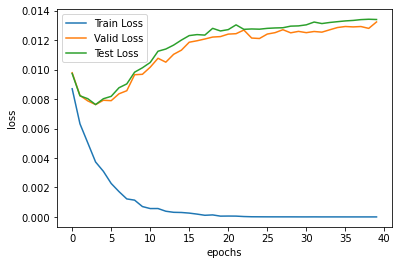

In [110]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(np.arange(len(BN_train_loss)), BN_train_loss)
plt.plot(np.arange(len(BN_valid_loss)), BN_valid_loss)
plt.plot(np.arange(len(BN_test_loss)), BN_test_loss)
plt.legend(['Train Loss','Valid Loss','Test Loss'])

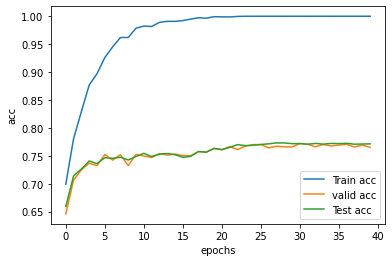

In [111]:
#准确率
plt.xlabel('epochs')
plt.ylabel('acc')
plt.plot(np.arange(len(BN_train_acc)), BN_train_acc)
plt.plot(np.arange(len(BN_valid_acc)), BN_valid_acc)
plt.plot(np.arange(len(BN_test_acc)), BN_test_acc)
plt.legend(['Train acc','valid acc','Test acc'])

In [112]:
print('验证集最高准确率: ', max(BN_valid_acc), '\t索引:', BN_valid_acc.index(max(BN_valid_acc)))
print('测试集最高准确率: ', max(BN_test_acc), '\t索引:',BN_test_acc.index(max(BN_test_acc)))
pos = BN_valid_acc.index(max(BN_valid_acc))
BN_max_test_acc = BN_test_acc[pos]
print('验证集最高准确率的模型对应的测试集准确率：', BN_max_test_acc, '\t索引:', pos)

验证集最高准确率:  0.772 	索引: 30
测试集最高准确率:  0.7731 	索引: 27
验证集最高准确率的模型对应的测试集准确率： 0.7718 	索引: 30


# 不使用 BN

In [113]:
class Net(nn.Module):
    def __init__(self,num_classes=10):
        super(Net,self).__init__()
        self.features = nn.Sequential(  #打包
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),      # input[6, 32, 32]  output[16, 32, 32] 
            nn.ReLU(inplace=True),      
            nn.MaxPool2d(kernel_size=2),                              # output[16, 16, 16] 
            nn.Conv2d(16, 48, kernel_size=3, stride=1, padding=1),     # output[48, 16, 16]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),                              # output[16, 8, 8]
            nn.Conv2d(48, 96, kernel_size=3, stride=1, padding=0),    # output[96, 6, 6]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)                               # output[96, 3, 3]
        )
        self.classifier = nn.Sequential(
            nn.Linear(96*3*3,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,128),
            nn.ReLU(inplace=True),
            nn.Linear(128,num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1) 
        x = self.classifier(x)
        return x
        

In [114]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model = model.to(device)
print(model)

Net(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=864, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [115]:
# 损失器
criterion = nn.CrossEntropyLoss().to(device)
# 优化器
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=0) 

In [116]:
train_loss = []        
valid_loss = []  
test_loss = []
train_acc  = []    
valid_acc = [] 
test_acc  = []     

In [117]:
for epoch in range(num_epoches):
    print('epoch:',epoch+1)

    model.train()
    for _,data in enumerate(train_loader,0):
        inputs, labels = data[0],data[1]
        inputs = inputs.view(train_batch_size, -1, 32, 32)  
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # 每次训练梯度清零
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    model.eval()
    running_loss = 0.0
    correct = 0             
    total = 0             
    with torch.no_grad(): 
        for _,data in enumerate(train_loader,0):
            inputs, labels = data
            inputs = inputs.view(test_batch_size, -1, 32, 32)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
            total += labels.size(0)                   # 总样本个数加 1
            correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
    train_loss.append(running_loss/total)
    train_acc.append(correct / total)
    print("训练集上的损失：%.3f" % (running_loss / total))
    print("训练集上的准确率：%.3f" % (correct / total))


    model.eval()
    running_loss = 0.0
    correct = 0             
    total = 0             
    with torch.no_grad(): 
        for _,data in enumerate(valid_loader,0):
            inputs, labels = data
            inputs = inputs.view(test_batch_size, -1, 32, 32)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
            total += labels.size(0)                   # 总样本个数加 1
            correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
    valid_loss.append(running_loss / total)
    valid_acc.append(correct / total)
    print("验证集上的损失：%.3f" % (running_loss / total))
    print("验证集上的准确率：%.3f" % (correct / total))
    
    
    model.eval()
    running_loss = 0.0
    correct = 0            
    total = 0             
    with torch.no_grad(): 
        for _,data in enumerate(test_loader,0):
            inputs, labels = data
            inputs = inputs.view(test_batch_size, -1, 32, 32)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
            total += labels.size(0)                   # 总样本个数加 1
            correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
    test_loss.append(running_loss / total)
    test_acc.append(correct / total)
    print("测试集上的损失：%.3f" % (running_loss / total))
    print("测试集上的准确率：%.3f" % (correct / total))

epoch: 1
训练集上的损失：0.015
训练集上的准确率：0.427
验证集上的损失：0.015
验证集上的准确率：0.421
测试集上的损失：0.015
测试集上的准确率：0.430
epoch: 2
训练集上的损失：0.011
训练集上的准确率：0.608
验证集上的损失：0.011
验证集上的准确率：0.578
测试集上的损失：0.011
测试集上的准确率：0.592
epoch: 3
训练集上的损失：0.010
训练集上的准确率：0.654
验证集上的损失：0.010
验证集上的准确率：0.624
测试集上的损失：0.010
测试集上的准确率：0.627
epoch: 4
训练集上的损失：0.008
训练集上的准确率：0.714
验证集上的损失：0.009
验证集上的准确率：0.672
测试集上的损失：0.009
测试集上的准确率：0.670
epoch: 5
训练集上的损失：0.007
训练集上的准确率：0.758
验证集上的损失：0.009
验证集上的准确率：0.687
测试集上的损失：0.009
测试集上的准确率：0.693
epoch: 6
训练集上的损失：0.006
训练集上的准确率：0.807
验证集上的损失：0.008
验证集上的准确率：0.707
测试集上的损失：0.008
测试集上的准确率：0.710
epoch: 7
训练集上的损失：0.005
训练集上的准确率：0.825
验证集上的损失：0.009
验证集上的准确率：0.704
测试集上的损失：0.009
测试集上的准确率：0.707
epoch: 8
训练集上的损失：0.004
训练集上的准确率：0.872
验证集上的损失：0.008
验证集上的准确率：0.722
测试集上的损失：0.008
测试集上的准确率：0.726
epoch: 9
训练集上的损失：0.003
训练集上的准确率：0.909
验证集上的损失：0.009
验证集上的准确率：0.727
测试集上的损失：0.009
测试集上的准确率：0.732
epoch: 10
训练集上的损失：0.002
训练集上的准确率：0.925
验证集上的损失：0.009
验证集上的准确率：0.730
测试集上的损失：0.009
测试集上的准确率：0.727
epoch: 11
训练集上的损失：0.002
训练集上的准确率：0.935


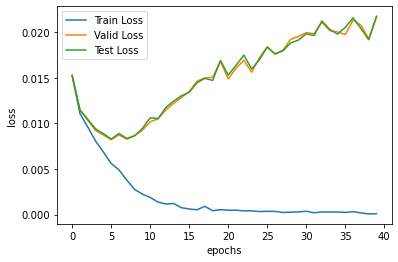

In [118]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(np.arange(len(train_loss)), train_loss)
plt.plot(np.arange(len(valid_loss)), valid_loss)
plt.plot(np.arange(len(test_loss)), test_loss)
plt.legend(['Train Loss','Valid Loss','Test Loss'])

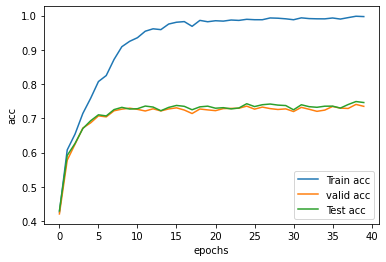

In [119]:
#准确率
plt.xlabel('epochs')
plt.ylabel('acc')
plt.plot(np.arange(len(train_acc)), train_acc)
plt.plot(np.arange(len(valid_acc)), valid_acc)
plt.plot(np.arange(len(test_acc)), test_acc)
plt.legend(['Train acc','valid acc','Test acc'])

In [120]:
print('验证集最高准确率: ', max(valid_acc), '\t索引:', valid_acc.index(max(valid_acc)))
print('测试集最高准确率: ', max(test_acc), '\t索引:',test_acc.index(max(test_acc)))
pos = valid_acc.index(max(valid_acc))
max_test_acc = test_acc[pos]
print('验证集最高准确率的模型对应的测试集准确率：', max_test_acc, '\t索引:', pos)

验证集最高准确率:  0.7406 	索引: 38
测试集最高准确率:  0.749 	索引: 38
验证集最高准确率的模型对应的测试集准确率： 0.749 	索引: 38


# 对比有无 BN 情况下的 loss 和 acc

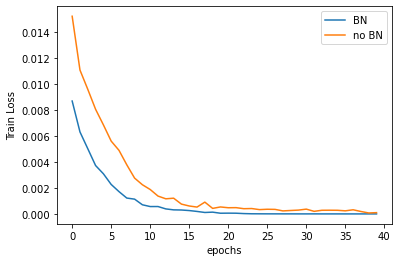

In [121]:
# 对比训练集loss
plt.xlabel('epochs')
plt.ylabel('Train Loss')
plt.plot(np.arange(len(BN_train_loss)), BN_train_loss)
plt.plot(np.arange(len(train_loss)), train_loss)
plt.legend(['BN','no BN'])

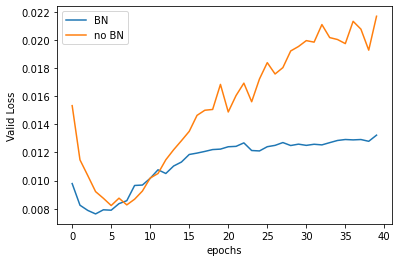

In [122]:
# 对比验证集loss
plt.xlabel('epochs')
plt.ylabel('Valid Loss')
plt.plot(np.arange(len(BN_valid_loss)), BN_valid_loss)
plt.plot(np.arange(len(valid_loss)), valid_loss)
plt.legend(['BN','no BN'])

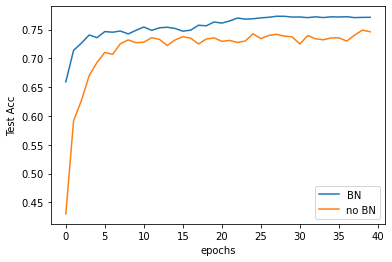

In [123]:
# 对比测试集acc
plt.xlabel('epochs')
plt.ylabel('Test Acc')
plt.plot(np.arange(len(BN_test_acc)), BN_test_acc)
plt.plot(np.arange(len(test_acc)), test_acc)
plt.legend(['BN','no BN'])

In [124]:
print("有 BN 测试集最高准确率:",max(BN_test_acc))
print("无 BN 测试集最高准确率:",max(test_acc))

有 BN 测试集最高准确率: 0.7731
无 BN 测试集最高准确率: 0.749
